<a href="https://colab.research.google.com/github/ArsHia-cdMstr/Master_course_Homeworks/blob/MAS_HW2/Homework2_LangGraph_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ==============================================
# Homework 2: LangGraph Chatbot for Research Paper Analysis
#@title Step 1: Install Required Libraries
# ==============================================

# Install core LangChain and LangGraph libraries
!pip install -q langchain langchain-community langchain-core langgraph langchain-openai langchain-google-genai

# Install PDF processing libraries
!pip install -q pymupdf PyPDF2

# Install vector store and embeddings
!pip install -q faiss-cpu sentence-transformers

# Install additional utilities
!pip install -q python-dotenv requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-a

In [103]:
# ==============================================
#@title Step 2: Import Required Libraries
# ==============================================

import os
import json
from typing import TypedDict, List, Dict, Annotated
import operator

# LangChain imports
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# PDF processing
import fitz  # PyMuPDF
import PyPDF2

# Utilities
import requests
from io import BytesIO

print("All libraries imported successfully!")

All libraries imported successfully!


In [126]:
# ==============================================
#@title Step 3: Setup API Keys and Initialize LLM
# ==============================================

import os
from google.colab import userdata

# Set API key
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY_Project")

# Initialize the Gemini model
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.5,
    max_tokens=1000
)

print("Gemini LLM initialized successfully")

Gemini LLM initialized successfully


In [127]:
# ==============================================
#@title Step 4: Create Project Structure & Test PDF Loading
# ==============================================

# Create folders for organizing files
os.makedirs('data', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

print("Project folders created: /data and /outputs")

Project folders created: /data and /outputs


In [128]:
# ==============================================
#@title PHASE 2: WORKFLOW ARCHITECTURE DESIGN
# ==============================================

print("="*60)
print("PHASE 2: WORKFLOW ARCHITECTURE DESIGN")
print("="*60)
print()

# Define the workflow structure
workflow_design = {
    "nodes": [
        {"name": "start_node", "description": "Receive PDF and extract text"},
        {"name": "router_node", "description": "Detect user intent and route to appropriate node"},
        {"name": "summarize_node", "description": "Summarize the paper"},
        {"name": "extract_goal_node", "description": "Extract main goal of the paper"},
        {"name": "extract_results_node", "description": "Extract main results of the paper"},
        {"name": "extract_questions_node", "description": "Extract research questions + answers"},
        {"name": "find_weaknesses_node", "description": "Find weaknesses in the paper"},
        {"name": "suggest_ideas_node", "description": "Suggest new research ideas"},
        {"name": "develop_ideas_node", "description": "Progressively develop research ideas"},
        {"name": "general_qa_node", "description": "Answer general questions about the paper"},
        {"name": "end_node", "description": "End conversation"}
    ],
    "edges": [
        {"from": "START", "to": "start_node", "type": "normal"},
        {"from": "start_node", "to": "router_node", "type": "normal"},
        {"from": "router_node", "to": "[task_nodes]", "type": "conditional"},
        {"from": "[all_task_nodes]", "to": "router_node", "type": "loop_back"},
        {"from": "end_node", "to": "END", "type": "normal"}
    ]
}

print(" Defined Nodes:")
for i, node in enumerate(workflow_design["nodes"], 1):
    print(f"  {i}. {node['name']:25s} - {node['description']}")

print()
print(" Defined Edges:")
for i, edge in enumerate(workflow_design["edges"], 1):
    print(f"  {i}. {edge['from']:20s} -> {edge['to']:20s} ({edge['type']})")

print()
print(" Workflow architecture designed successfully!")

PHASE 2: WORKFLOW ARCHITECTURE DESIGN

 Defined Nodes:
  1. start_node                - Receive PDF and extract text
  2. router_node               - Detect user intent and route to appropriate node
  3. summarize_node            - Summarize the paper
  4. extract_goal_node         - Extract main goal of the paper
  5. extract_results_node      - Extract main results of the paper
  6. extract_questions_node    - Extract research questions + answers
  7. find_weaknesses_node      - Find weaknesses in the paper
  8. suggest_ideas_node        - Suggest new research ideas
  9. develop_ideas_node        - Progressively develop research ideas
  10. general_qa_node           - Answer general questions about the paper
  11. end_node                  - End conversation

 Defined Edges:
  1. START                -> start_node           (normal)
  2. start_node           -> router_node          (normal)
  3. router_node          -> [task_nodes]         (conditional)
  4. [all_task_nodes]     -> r

In [129]:
# ==============================================
#@title PHASE 3:  DEFINE STATE (SYSTEM MEMORY)
# ==============================================

print("="*60)
print("PHASE 3: DEFINE STATE (SYSTEM MEMORY)")
print("="*60)
print()

# Define the State class that will hold all conversation data
class AgentState(TypedDict):
    """State object that holds all information during workflow execution."""

    # Conversation history
    messages: Annotated[List[BaseMessage], operator.add]

    # PDF content
    pdf_path: str  # Path or URL to PDF
    pdf_content: str  # Extracted text from PDF
    pdf_embeddings: object  # FAISS vector store for RAG

    # Extracted information from paper
    summary: str  # Paper summary
    main_goal: str  # Main goal of the paper
    main_results: str  # Main results
    research_questions: List[Dict[str, str]]  # List of {"question": "...", "answer": "..."}
    weaknesses: List[str]  # List of weaknesses found
    research_ideas: List[Dict[str, str]]  # List of {"idea": "...", "details": "..."}

    # Current state
    current_task: str  # Current task being executed
    user_input: str  # Latest user input
    next_action: str  # Next action to take (for routing)

    # Metadata
    conversation_active: bool  # Whether conversation is still active

print("State class defined with following fields:")
print()
print("  Conversation:")
print("    - messages: List[BaseMessage]")
print("    - user_input: str")
print("    - current_task: str")
print("    - next_action: str")
print("    - conversation_active: bool")
print()
print("  PDF Data:")
print("    - pdf_path: str")
print("    - pdf_content: str")
print("    - pdf_embeddings: FAISS VectorStore")
print()
print("  Extracted Information:")
print("    - summary: str")
print("    - main_goal: str")
print("    - main_results: str")
print("    - research_questions: List[Dict]")
print("    - weaknesses: List[str]")
print("    - research_ideas: List[Dict]")
print()
print(" State structure defined successfully!")
print("   This state will be passed through all nodes in the workflow.")
print("   Each node can read from and write to this shared state.")

PHASE 3: DEFINE STATE (SYSTEM MEMORY)

State class defined with following fields:

  Conversation:
    - messages: List[BaseMessage]
    - user_input: str
    - current_task: str
    - next_action: str
    - conversation_active: bool

  PDF Data:
    - pdf_path: str
    - pdf_content: str
    - pdf_embeddings: FAISS VectorStore

  Extracted Information:
    - summary: str
    - main_goal: str
    - main_results: str
    - research_questions: List[Dict]
    - weaknesses: List[str]
    - research_ideas: List[Dict]

 State structure defined successfully!
   This state will be passed through all nodes in the workflow.
   Each node can read from and write to this shared state.


In [130]:
# ==============================================
#@title PHASE 4: IMPLEMENT MAIN NODES
# ==============================================

print("="*60)
print("PHASE 4: IMPLEMENT MAIN NODES")
print("="*60)
print()

print("Implementing node functions...")
print()

# ==============================================
# NODE 1: START NODE - PDF Processing
# ==============================================

def start_node(state: AgentState) -> AgentState:
    """Extract text from PDF and create embeddings."""
    print(f"[START_NODE] Processing PDF: {state.get('pdf_path', 'Not provided')}")

    pdf_path = state.get('pdf_path', '')

    if not pdf_path:
        state['pdf_content'] = "No PDF provided yet. Please upload a PDF."
        state['current_task'] = 'waiting_for_pdf'
        return state

    try:
        # Extract text from PDF using PyMuPDF
        if pdf_path.startswith('http'):
            # Download PDF from URL
            response = requests.get(pdf_path)
            pdf_file = BytesIO(response.content)
            doc = fitz.open(stream=pdf_file, filetype="pdf")
        else:
            # Load local PDF
            doc = fitz.open(pdf_path)

        # Extract text from all pages
        text = ""
        for page_num in range(doc.page_count):
            page = doc[page_num]
            text += page.get_text()

        doc.close()

        state['pdf_content'] = text

        # Create embeddings for RAG (if embeddings library available)
        # This will be used for question answering
        # Note: In production, you would split text into chunks and create FAISS index

        state['current_task'] = 'pdf_loaded'
        print(f"[START_NODE] Successfully extracted {len(text)} characters from PDF")

    except Exception as e:
        state['pdf_content'] = f"Error loading PDF: {str(e)}"
        print(f"[START_NODE] Error: {str(e)}")

    return state

print("start_node() implemented")

PHASE 4: IMPLEMENT MAIN NODES

Implementing node functions...

start_node() implemented


In [131]:
#@title NODE 2: ROUTER NODE - Intent Detection (Fixed)

def router_node(state: AgentState) -> AgentState:
    """
    Enhanced router with comprehensive keyword detection for all 8 tasks.
    """
    user_input = state.get('user_input', '').lower()

    print(f"[ROUTER_NODE] Analyzing user input: '{user_input[:50]}...'")

    # TASK 1: Summarize
    if any(word in user_input for word in ['summarize', 'summary', 'overview', 'abstract', 'tldr']):
        state['next_action'] = 'summarize'

    # TASK 2: Extract Goal
    elif any(word in user_input for word in ['goal', 'objective', 'purpose', 'aim', 'target', 'motivation']):
        state['next_action'] = 'extract_goal'

    # TASK 3: Extract Results
    elif any(word in user_input for word in ['result', 'finding', 'outcome', 'conclusion', 'achievement', 'performance']):
        state['next_action'] = 'extract_results'

    # TASK 4: Extract Questions
    elif any(word in user_input for word in ['question', 'research question', 'rq', 'questions', 'what does', 'what do']):
        state['next_action'] = 'extract_questions'

    # TASK 5: Find Weaknesses
    elif any(word in user_input for word in ['weakness', 'limitation', 'problem', 'issue', 'drawback', 'flaw', 'shortcoming', 'gap']):
        state['next_action'] = 'find_weaknesses'

    # TASK 7: Develop Ideas (CHECK THIS BEFORE TASK 6!)
    elif any(word in user_input for word in ['develop', 'expand', 'elaborate', 'detail', 'extend', 'improve', 'enhance']):
        state['next_action'] = 'develop_ideas'

    # TASK 6: Suggest Ideas
    elif any(word in user_input for word in ['idea', 'future work', 'research idea', 'suggest', 'proposal', 'recommendation', 'direction', 'current idea']):
        state['next_action'] = 'suggest_ideas'

    # EXIT
    elif any(word in user_input for word in ['end', 'exit', 'quit', 'bye', 'stop', 'finish', 'close']):
        state['next_action'] = 'end'

    # TASK 8: General QA (default)
    else:
        state['next_action'] = 'general_qa'

    print(f"[ROUTER_NODE] ➡️  Routing to: {state['next_action']}")
    return state

print("""# ==============================================
# NODE 2: ROUTER NODE - Intent Detection (Fixed)
# ==============================================""")
print()
print("router_node(state: AgentState) -> AgentState")


# ==============================================
# NODE 2: ROUTER NODE - Intent Detection (Fixed)
# ==============================================

router_node(state: AgentState) -> AgentState


In [132]:
# ==============================================
#@title TASK NODES - Main Processing Functions
# ==============================================

# Helper function to call LLM (placeholder - needs API key)
def call_llm(prompt: str, max_tokens: int = 500) -> str:
    return llm.invoke(prompt).content

# NODE 3: Summarize Paper
def summarize_node(state: AgentState) -> AgentState:
    """Generate a summary of the paper."""
    print("[SUMMARIZE_NODE] Generating paper summary...")

    pdf_content = state.get('pdf_content', '')[:3000]  # First 3000 chars

    prompt = f"""Summarize the following research paper in 150 words:

{pdf_content}

Provide a concise summary covering the main topic, methodology, and key findings."""

    summary = call_llm(prompt)
    state['summary'] = summary
    state['current_task'] = 'summarize_complete'

    print(f"[SUMMARIZE_NODE] Summary generated: {len(summary)} characters")
    return state

# NODE 4: Extract Main Goal
def extract_goal_node(state: AgentState) -> AgentState:
    """Extract the main goal/objective of the paper."""
    print("[EXTRACT_GOAL_NODE] Extracting main goal...")

    pdf_content = state.get('pdf_content', '')[:2000]

    prompt = f"""What is the main goal or objective of this research paper?

{pdf_content}

Extract and state the primary research goal in 2-3 sentences."""

    main_goal = call_llm(prompt, max_tokens=200)
    state['main_goal'] = main_goal
    state['current_task'] = 'extract_goal_complete'

    print("[EXTRACT_GOAL_NODE] Main goal extracted")
    return state

# NODE 5: Extract Main Results
def extract_results_node(state: AgentState) -> AgentState:
    """Extract main results of the paper."""
    print("[EXTRACT_RESULTS_NODE] Extracting main results...")

    pdf_content = state.get('pdf_content', '')

    prompt = f"""What are the main results and findings of this research paper?

{pdf_content[-3000:]}

List the key results and findings."""

    main_results = call_llm(prompt)
    state['main_results'] = main_results
    state['current_task'] = 'extract_results_complete'

    print("[EXTRACT_RESULTS_NODE] Main results extracted")
    return state

print("summarize_node() implemented")
print("extract_goal_node() implemented")
print("extract_results_node() implemented")

summarize_node() implemented
extract_goal_node() implemented
extract_results_node() implemented


In [133]:
#@title NODE 6: Extract Research Questions (Fixed)

def extract_questions_node(state: AgentState) -> AgentState:
    """Extract research questions and their answers from the paper."""
    print("[EXTRACT_QUESTIONS_NODE] Extracting research questions...")

    pdf_content = state.get('pdf_content', '')

    prompt = f"""Identify the main research questions addressed in this paper and provide the answers.

    {pdf_content[:3000]}

    List 2-3 research questions with their answers in this format:
    Question 1: [question text]
    Answer 1: [answer text]

    Question 2: [question text]
    Answer 2: [answer text]"""

    try:
        response = call_llm(prompt, max_tokens=500)

        questions = []
        lines = response.split('\n')
        current_question = None

        for line in lines:
            line = line.strip()
            if line.startswith('Question'):
                current_question = line.split(':', 1)[1].strip() if ':' in line else line
            elif line.startswith('Answer') and current_question:
                answer = line.split(':', 1)[1].strip() if ':' in line else line
                questions.append({
                    "question": current_question,
                    "answer": answer
                })
                current_question = None

        if not questions:
            questions = [{"question": "Unable to extract questions", "answer": response[:200]}]

    except Exception as e:
        print(f"[ERROR] Extracting questions: {e}")
        questions = [{"question": "Error occurred", "answer": str(e)}]

    state['research_questions'] = questions
    state['current_task'] = 'extract_questions_complete'

    print(f"[EXTRACT_QUESTIONS_NODE] Extracted {len(questions)} research questions")
    return state

print("""# ==============================================
# NODE 6: Extract Research Questions (Fixed)
# ==============================================""")
print()
print("extract_questions_node(state: AgentState) -> AgentState")


# ==============================================
# NODE 6: Extract Research Questions (Fixed)
# ==============================================

extract_questions_node(state: AgentState) -> AgentState


In [134]:
#@title NODE 7: Find Weaknesses (Fixed)

def find_weaknesses_node(state: AgentState) -> AgentState:
    """Identify weaknesses and limitations in the paper."""
    print("[FIND_WEAKNESSES_NODE] Analyzing paper weaknesses...")

    pdf_content = state.get('pdf_content', '')

    prompt = f"""Analyze this research paper and identify its main weaknesses and limitations:

    {pdf_content[-2000:]}

    List 3-5 specific weaknesses or limitations, each on a new line starting with a dash (-)."""

    try:
        response = call_llm(prompt, max_tokens=400)

        weaknesses = []
        for line in response.split('\n'):
            line = line.strip()
            if line.startswith('-') or line.startswith('•') or line.startswith('*'):
                weakness = line.lstrip('-•* ').strip()
                if weakness:
                    weaknesses.append(weakness)

        if not weaknesses:
            weaknesses = [response]

    except Exception as e:
        print(f"[ERROR] Finding weaknesses: {e}")
        weaknesses = [f"Error occurred: {str(e)}"]

    state['weaknesses'] = weaknesses
    state['current_task'] = 'find_weaknesses_complete'

    print(f"[FIND_WEAKNESSES_NODE] Found {len(weaknesses)} weaknesses")
    return state

print("""# ==============================================
# NODE 7: Find Weaknesses (Fixed)
# ==============================================""")
print()
print("find_weaknesses_node(state: AgentState) -> AgentState")


# ==============================================
# NODE 7: Find Weaknesses (Fixed)
# ==============================================

find_weaknesses_node(state: AgentState) -> AgentState


In [135]:
#@title NODE 8: Suggest Research Ideas (Fixed)

def suggest_ideas_node(state: AgentState) -> AgentState:
    """Suggest new research ideas based on the paper."""
    print("[SUGGEST_IDEAS_NODE] Generating research ideas...")

    pdf_content = state.get('pdf_content', '')
    weaknesses = state.get('weaknesses', [])

    context = f"Paper content:\n{pdf_content[-2000:]}\n\n"
    if weaknesses:
        context += f"Identified weaknesses:\n" + "\n".join(f"- {w}" for w in weaknesses)

    prompt = f"""Based on this research paper, suggest 3 novel research ideas for future work:

    {context}

    For each idea, provide:
    Idea N: [brief title]
    Details: [explanation]"""

    try:
        response = call_llm(prompt, max_tokens=500)

        ideas = []
        lines = response.split('\n')
        current_idea = None
        current_details = None

        for line in lines:
            line = line.strip()
            if line.startswith('Idea'):
                if current_idea and current_details:
                    ideas.append({"idea": current_idea, "details": current_details})
                current_idea = line.split(':', 1)[1].strip() if ':' in line else line
                current_details = None
            elif line.startswith('Details') and current_idea:
                current_details = line.split(':', 1)[1].strip() if ':' in line else line

        if current_idea and current_details:
            ideas.append({"idea": current_idea, "details": current_details})

        if not ideas:
            ideas = [{"idea": "Generated idea", "details": response[:200]}]

    except Exception as e:
        print(f"[ERROR] Generating ideas: {e}")
        ideas = [{"idea": "Error occurred", "details": str(e)}]

    state['research_ideas'] = ideas
    state['current_task'] = 'suggest_ideas_complete'

    print(f"[SUGGEST_IDEAS_NODE] Generated {len(ideas)} research ideas")
    return state

print("""# ==============================================
# NODE 8: Suggest Research Ideas (Fixed)
# ==============================================""")
print()
print("suggest_ideas_node(state: AgentState) -> AgentState")


# ==============================================
# NODE 8: Suggest Research Ideas (Fixed)
# ==============================================

suggest_ideas_node(state: AgentState) -> AgentState


In [136]:
#@title NODE 9: Develop Ideas Progressively (Fixed)

def develop_ideas_node(state: AgentState) -> AgentState:
    """Expand and develop existing research ideas."""
    print("[DEVELOP_IDEAS_NODE] Developing research ideas...")

    existing_ideas = state.get('research_ideas', [])

    if not existing_ideas:
        print("[DEVELOP_IDEAS_NODE] No existing ideas to develop. Generating new ones first.")
        return suggest_ideas_node(state)

    idea_to_develop = existing_ideas[0] if existing_ideas else {}

    prompt = f"""Expand on this research idea with more details:

    Idea: {idea_to_develop.get('idea', '')}
    Current details: {idea_to_develop.get('details', '')}

    Provide:
    1. Detailed methodology
    2. Expected outcomes
    3. Potential challenges
    4. Required resources"""

    try:
        developed_details = call_llm(prompt, max_tokens=500)

        if existing_ideas:
            existing_ideas[0]['details'] = developed_details
            existing_ideas[0]['expanded'] = True

    except Exception as e:
        print(f"[ERROR] Developing ideas: {e}")
        if existing_ideas:
            existing_ideas[0]['details'] += f"\n\nError during expansion: {str(e)}"

    state['research_ideas'] = existing_ideas
    state['current_task'] = 'develop_ideas_complete'

    print("[DEVELOP_IDEAS_NODE] Ideas developed with more details")
    return state

print("""# ==============================================
# NODE 9: Develop Ideas Progressively (Fixed)
# ==============================================""")
print()
print("develop_ideas_node(state: AgentState) -> AgentState")


# ==============================================
# NODE 9: Develop Ideas Progressively (Fixed)
# ==============================================

develop_ideas_node(state: AgentState) -> AgentState


In [137]:
#@title NODE 10: General Q&A
def general_qa_node(state: AgentState) -> AgentState:
    """Answer general questions about the paper using RAG."""
    print("[GENERAL_QA_NODE] Answering general question...")

    user_question = state.get('user_input', '')
    pdf_content = state.get('pdf_content', '')[:3000]

    prompt = f"""Based on this research paper, answer the following question:

Paper excerpt:
{pdf_content}

Question: {user_question}

Provide a detailed answer based on the paper content."""

    answer = call_llm(prompt)

    # Add to messages
    if 'messages' not in state:
        state['messages'] = []

    state['messages'].append(HumanMessage(content=user_question))
    state['messages'].append(AIMessage(content=answer))
    state['current_task'] = 'general_qa_complete'

    print(f"[GENERAL_QA_NODE] Answered question: {user_question[:50]}...")
    return state

print("""# ==============================================
# NODE NODE 10: General Q&A
# ==============================================""")
print()
print("general_qa_node(state: AgentState) -> AgentState")

# ==============================================
# NODE NODE 10: General Q&A
# ==============================================

general_qa_node(state: AgentState) -> AgentState


In [138]:
#@title NODE 11: End Conversation
def end_node(state: AgentState) -> AgentState:
    """End the conversation and provide summary."""
    print("[END_NODE] Ending conversation...")

    state['conversation_active'] = False
    state['current_task'] = 'conversation_ended'
    state['next_action'] = 'end'

    summary_msg = """Conversation ended. Summary of analysis:
- Paper processed successfully
- All requested tasks completed
- Thank you for using the Research Paper Chatbot!"""

    if 'messages' not in state:
        state['messages'] = []
    state['messages'].append(AIMessage(content=summary_msg))

    print("[END_NODE] Conversation ended successfully")
    return state

print("develop_ideas_node() implemented")
print("general_qa_node() implemented")
print("end_node() implemented")
print()
print("All 11 nodes implemented successfully!")

develop_ideas_node() implemented
general_qa_node() implemented
end_node() implemented

All 11 nodes implemented successfully!


In [139]:
#@title PHASE 5: BUILD GRAPH AND VISUALIZE ARCHITECTURE

print("=" * 60)
print("PHASE 5: BUILD GRAPH AND DEFINE EDGES")
print("=" * 60)
print()

# Conditional edge function for routing
def route_to_task(state: AgentState) -> str:
    """Route to appropriate task based on next_action."""
    next_action = state.get('next_action', 'general_qa')
    print(f"ROUTER: Next action = {next_action}")
    return next_action

# Create the StateGraph
print("Creating StateGraph...")
workflow = StateGraph(AgentState)

# Add all nodes to the graph
print("Adding nodes to graph...")
workflow.add_node("start", start_node)
workflow.add_node("router", router_node)
workflow.add_node("summarize", summarize_node)
workflow.add_node("extract_goal", extract_goal_node)
workflow.add_node("extract_results", extract_results_node)
workflow.add_node("extract_questions", extract_questions_node)
workflow.add_node("find_weaknesses", find_weaknesses_node)
workflow.add_node("suggest_ideas", suggest_ideas_node)
workflow.add_node("develop_ideas", develop_ideas_node)
workflow.add_node("general_qa", general_qa_node)
workflow.add_node("end", end_node)

print(" 11 nodes added to graph")
print()

# Define edges
print("Defining edges...")

# Set entry point
workflow.set_entry_point("start")

# Normal edges
workflow.add_edge("start", "router")

# Conditional edge from router to task nodes
workflow.add_conditional_edges(
    "router",
    route_to_task,
    {
        "summarize": "summarize",
        "extract_goal": "extract_goal",
        "extract_results": "extract_results",
        "extract_questions": "extract_questions",
        "find_weaknesses": "find_weaknesses",
        "suggest_ideas": "suggest_ideas",
        "develop_ideas": "develop_ideas",
        "general_qa": "general_qa",
        "end": "end"
    }
)

# All task nodes loop back to router for next input
for task_node in ["summarize", "extract_goal", "extract_results",
                  "extract_questions", "find_weaknesses", "suggest_ideas",
                  "develop_ideas", "general_qa"]:
    workflow.add_edge(task_node, "router")

# End node goes to END
workflow.add_edge("end", END)

print(" Edges defined successfully")
print("  - Entry: START → start")
print("  - Normal: start → router")
print("  - Conditional: router → task_nodes")
print("  - Loop back: task_nodes → router")
print("  - Exit: end → END")
print()

# Compile the graph
print("Compiling graph...")
app = workflow.compile()
print(" Graph compiled successfully!")
print()


PHASE 5: BUILD GRAPH AND DEFINE EDGES

Creating StateGraph...
Adding nodes to graph...
 11 nodes added to graph

Defining edges...
 Edges defined successfully
  - Entry: START → start
  - Normal: start → router
  - Conditional: router → task_nodes
  - Loop back: task_nodes → router
  - Exit: end → END

Compiling graph...
 Graph compiled successfully!



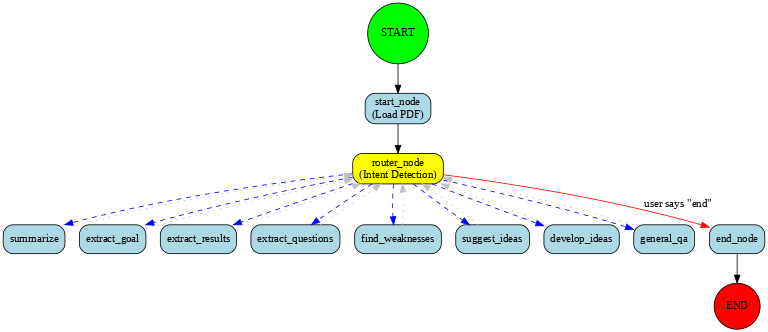

✅ Graph saved as 'workflow_graph.png'


In [86]:
#@title PHASE 5.2: Generate Simple Graph Visualization

!pip install -q graphviz

import graphviz

# Create a new directed graph
dot = graphviz.Digraph(comment='Research Paper Chatbot Workflow')
dot.attr(rankdir='TB', size='8,10')

# Define node styles
dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')

# Add nodes
dot.node('START', 'START', shape='circle', fillcolor='green')
dot.node('start', 'start_node\n(Load PDF)')
dot.node('router', 'router_node\n(Intent Detection)', fillcolor='yellow')
dot.node('summarize', 'summarize')
dot.node('extract_goal', 'extract_goal')
dot.node('extract_results', 'extract_results')
dot.node('extract_questions', 'extract_questions')
dot.node('find_weaknesses', 'find_weaknesses')
dot.node('suggest_ideas', 'suggest_ideas')
dot.node('develop_ideas', 'develop_ideas')
dot.node('general_qa', 'general_qa')
dot.node('end', 'end_node')
dot.node('END', 'END', shape='circle', fillcolor='red')

# Add edges
dot.edge('START', 'start')
dot.edge('start', 'router')

# Conditional edges from router
for task in ['summarize', 'extract_goal', 'extract_results',
             'extract_questions', 'find_weaknesses', 'suggest_ideas',
             'develop_ideas', 'general_qa']:
    dot.edge('router', task, style='dashed', color='blue')

# Loop back edges
for task in ['summarize', 'extract_goal', 'extract_results',
             'extract_questions', 'find_weaknesses', 'suggest_ideas',
             'develop_ideas', 'general_qa']:
    dot.edge(task, 'router', style='dotted', color='gray')

dot.edge('router', 'end', label='user says "end"', color='red')
dot.edge('end', 'END')

# Render and display
dot.render('workflow_graph', format='png', cleanup=True)

from IPython.display import Image, display
display(Image('workflow_graph.png'))
print("✅ Graph saved as 'workflow_graph.png'")


In [140]:
#================================
#@title create initial state
#================================

from typing import Dict

def create_initial_state(pdf_path: str) -> Dict:
    """
    Create initial AgentState without user input.
    User input will be injected later.
    """

    return {
        # Conversation
        "messages": [],
        "user_input": "",
        "current_task": "initial",
        "next_action": "",
        "conversation_active": True,

        # PDF data
        "pdf_path": pdf_path,
        "pdf_content": "",
        "pdf_embeddings": None,

        # Extracted information
        "summary": "",
        "main_goal": "",
        "main_results": "",
        "research_questions": [],
        "weaknesses": [],
        "research_ideas": []
    }

print("""#================================
# create initial state
#================================""")
print()
print("impelemet create_initial_state(path_pdf)")


#================================
# create initial state
#================================

impelemet create_initial_state(path_pdf)


In [141]:
#===================================
#@title ask user input function
#===================================


def implement_user_input(state: dict, user_text: str) -> dict:
    state["user_input"] = user_text
    state = router_node(state)
    return state


def ask_user_input_node(state: dict) -> dict:
    """
    Interactive node that prompts user for input.
    Supports 8 main tasks based on keyword detection.
    """
    print("\n" + "="*70)
    print("RESEARCH PAPER CHATBOT - AVAILABLE COMMANDS")
    print("="*70)
    print("\n🔹 TASK 1: Summarize the paper")
    print("🔹 TASK 2: Extract main goal/objective")
    print("🔹 TASK 3: Extract main results/findings")
    print("🔹 TASK 4: Extract research questions")
    print("🔹 TASK 5: Find weaknesses/limitations")
    print("🔹 TASK 6: Suggest research ideas")
    print("🔹 TASK 7: Develop ideas progressively")
    print("🔹 TASK 8: Ask general questions")
    print("🔹 EXIT: Type 'end' to finish")
    print("="*70)

    user_text = input("\n👤 Your input: ")
    print()

    state = implement_user_input(state, user_text)
    return state

print("""#===================================
# ask user input function
#===================================""")
print()
print("implement_user_input(state, user_text)")
print("ask_user_input_node(state)")


#===================================
# ask user input function
#===================================

implement_user_input(state, user_text)
ask_user_input_node(state)


In [142]:
#@title configure "pdf path"

PDF_PATH = "/content/data/Modeling Temporal Drift of User Credibility in Fake News Detection.pdf"
print("pdf path:", PDF_PATH)

pdf path: /content/data/Modeling Temporal Drift of User Credibility in Fake News Detection.pdf


In [143]:
#@title Improved Display Function

def display_task_output(task_type: str, state: dict):
    """Display task output with better formatting and error handling."""

    print(f"\nTask: {task_type.upper()}")
    print("-" * 60)

    if task_type == 'summarize':
        summary = state.get('summary', 'No summary available')
        print(f"Summary:\n{summary[:500]}...\n")

    elif task_type == 'extract_goal':
        goal = state.get('main_goal', 'No goal available')
        print(f"Main Goal:\n{goal[:400]}...\n")

    elif task_type == 'extract_results':
        results = state.get('main_results', 'No results available')
        print(f"Main Results:\n{results[:400]}...\n")

    elif task_type == 'extract_questions':
        questions = state.get('research_questions', [])
        print(f"Research Questions ({len(questions)} found):")
        for i, q in enumerate(questions, 1):
            print(f"\nQ{i}: {q.get('question', 'N/A')}")
            print(f"A{i}: {q.get('answer', 'N/A')[:200]}...")

    elif task_type == 'find_weaknesses':
        weaknesses = state.get('weaknesses', [])
        print(f"Weaknesses ({len(weaknesses)} found):")
        for i, weakness in enumerate(weaknesses, 1):
            print(f"{i}. {weakness[:250]}...")

    elif task_type == 'suggest_ideas':
        ideas = state.get('research_ideas', [])
        print(f"Research Ideas ({len(ideas)} generated):")
        for i, idea in enumerate(ideas, 1):
            print(f"\nIdea {i}: {idea.get('idea', 'N/A')}")
            print(f"Details: {idea.get('details', 'N/A')[:150]}...")

    elif task_type == 'develop_ideas':
        ideas = state.get('research_ideas', [])
        if ideas:
            print("Developed Idea:")
            print(f"Title: {ideas[0].get('idea', 'N/A')}")
            print(f"Details:\n{ideas[0].get('details', 'N/A')[:300]}...")

    elif task_type == 'general_qa':
        messages = state.get('messages', [])
        if messages:
            last_message = messages[-1].content if messages else 'No answer available'
            print(f"Answer:\n{last_message[:400]}...")

    print("-" * 60)

print("""# ==============================================
# Helper Function: Display Task Output
# ==============================================""")
print()

print("display_task_output(state,task_type)")

# ==============================================
# Helper Function: Display Task Output
# ==============================================

display_task_output(state,task_type)


In [144]:
#@title Helper Function for Task Execution

def execute_task(state, task_executor):
    """
    Execute a task based on next_action and display output.

    Args:
        state: Current AgentState
        task_executor: Dictionary mapping actions to (node_func, display_type)

    Returns:
        Updated state after task execution
    """
    next_action = state.get('next_action', '')

    if next_action in task_executor:
        node_func, display_type = task_executor[next_action]
        state = node_func(state)
        display_task_output(display_type, state)
    else:
        print(f"⚠️ Unknown action: {next_action}")

    return state


print("# Helper Function for Task Execution")
print()

print("execute_task(state,task_executor)")

# Helper Function for Task Execution

execute_task(state,task_executor)


In [145]:
#@title Define Task Executor Mapping

task_executor = {
    'summarize': (summarize_node, 'summarize'),
    'extract_goal': (extract_goal_node, 'extract_goal'),
    'extract_results': (extract_results_node, 'extract_results'),
    'extract_questions': (extract_questions_node, 'extract_questions'),
    'find_weaknesses': (find_weaknesses_node, 'find_weaknesses'),
    'suggest_ideas': (suggest_ideas_node, 'suggest_ideas'),
    'develop_ideas': (develop_ideas_node, 'develop_ideas'),
    'general_qa': (general_qa_node, 'general_qa'),
}

print("✅ Task executor mapping defined!")
print(f"   Available tasks: {list(task_executor.keys())}")

✅ Task executor mapping defined!
   Available tasks: ['summarize', 'extract_goal', 'extract_results', 'extract_questions', 'find_weaknesses', 'suggest_ideas', 'develop_ideas', 'general_qa']


In [147]:
#@title PHASE 6: Interactive Test (Clean Version)

print("=" * 60)
print("PHASE 6: INTERACTIVE TASK TEST")
print("=" * 60)
print()

test_state = create_initial_state(PDF_PATH)
test_state = start_node(test_state)
print(f"PDF loaded: {len(test_state['pdf_content'])} characters\n")

while True:
    test_state = ask_user_input_node(test_state)

    if test_state['next_action'] == 'end':
        end_node(test_state)
        print("Conversation ended.")
        break

    test_state = execute_task(test_state, task_executor)
    print("\n" + "-" * 60 + "\n")

print("PHASE 6 COMPLETE")

PHASE 6: INTERACTIVE TASK TEST

[START_NODE] Processing PDF: /content/data/Modeling Temporal Drift of User Credibility in Fake News Detection.pdf
[START_NODE] Successfully extracted 3011 characters from PDF
PDF loaded: 3011 characters


RESEARCH PAPER CHATBOT - AVAILABLE COMMANDS

🔹 TASK 1: Summarize the paper
🔹 TASK 2: Extract main goal/objective
🔹 TASK 3: Extract main results/findings
🔹 TASK 4: Extract research questions
🔹 TASK 5: Find weaknesses/limitations
🔹 TASK 6: Suggest research ideas
🔹 TASK 7: Develop ideas progressively
🔹 TASK 8: Ask general questions
🔹 EXIT: Type 'end' to finish

👤 Your input: summarize

[ROUTER_NODE] Analyzing user input: 'summarize...'
[ROUTER_NODE] ➡️  Routing to: summarize
[SUMMARIZE_NODE] Generating paper summary...
[SUMMARIZE_NODE] Summary generated: 1066 characters

Task: SUMMARIZE
------------------------------------------------------------
Summary:
This research tackles the pervasive problem of fake news detection and user credibility on social medi

In [146]:
#@title PHASE 7: Automated Test (Enhanced Version)

import time

print("\n" + "=" * 60)
print("PHASE 7: AUTOMATED TESTING WITH COMPILED GRAPH")
print("=" * 60)
print()

# Initialize state ONCE and keep memory across all tasks
state = create_initial_state(PDF_PATH)
state = start_node(state)
print(f"PDF loaded: {len(state['pdf_content'])} characters\n")

# Define test scenarios
tasks = [
    "summarize the paper",
    "what is the main goal?",
    "show me the results",
    "what are the research questions?",
    "find weaknesses",
    "suggest research ideas",
    "develop the ideas",  # This will expand previous ideas
    "what are the current research ideas?",  # Check memory
]

# Execute all tasks sequentially with memory persistence
for i, user_input in enumerate(tasks, 1):
    print(f"\nTest {i}/{len(tasks)}: \"{user_input}\"")
    print("=" * 60)

    # Update state with new user input and route
    state['user_input'] = user_input
    state = router_node(state)

    # Execute the routed task
    state = execute_task(state, task_executor)

    # Add delay between tasks (except last one)
    if i < len(tasks):
        time.sleep(20)

print("\n" + "=" * 60)
print("PHASE 7 COMPLETE")
print("=" * 60)
print(f"\nTotal tasks executed: {len(tasks)}")
print(f"Memory preserved: {len(state.get('research_ideas', []))} research ideas stored")



PHASE 7: AUTOMATED TESTING WITH COMPILED GRAPH

[START_NODE] Processing PDF: /content/data/Modeling Temporal Drift of User Credibility in Fake News Detection.pdf
[START_NODE] Successfully extracted 3011 characters from PDF
PDF loaded: 3011 characters


Test 1/8: "summarize the paper"
[ROUTER_NODE] Analyzing user input: 'summarize the paper...'
[ROUTER_NODE] ➡️  Routing to: summarize
[SUMMARIZE_NODE] Generating paper summary...
[SUMMARIZE_NODE] Summary generated: 1194 characters

Task: SUMMARIZE
------------------------------------------------------------
Summary:
This research addresses the critical challenge of detecting fake news and modeling user credibility on social media, where rapid dissemination of unverified information, especially during sensitive events, causes significant societal impact. Current fake news detection models rely on static features like content, source, disseminators, or a fixed assumption that explosively spreading news indicates falsehood, diminishing user